<a href="https://colab.research.google.com/github/abulhasanat/MachineLearning/blob/master/BERT_Multiclass_Webpage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [0]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
%%bash
pip install pytorch-pretrained-bert

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

In [0]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.model_selection import train_test_split

# DATA_ROOT = Path("..") / "input"
DATA_ROOT=Path('/content/drive/My Drive/Data/toxic_comments')
train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train_sample1.csv", "test1.csv"]]
# train, test = [pd.read_csv(DATA_ROOT / fname,sep='\t') for fname in ["train1.csv", "test1.csv"]]
val = train # we won't be using a validation set but you can easily create one using train_test_split

In [0]:
train.drop(['Unnamed: 0','id'],axis=1,inplace=True)
train.sample()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
34474,"Ad hominem aside, do you think that your educa...",0,0,0,0,0,0


In [0]:
# test=pd.read_csv(DATA_ROOT/'test1.csv')

In [0]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),NumericalizeProcessor(vocab=vocab)]

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [0]:
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

In [0]:
loss_func = nn.BCEWithLogitsLoss()

In [0]:
from fastai.callbacks import *
device_cuda = torch.device("cuda")
learner = Learner(
    databunch, bert_model,
    loss_func=loss_func
)
if config.use_fp16: learner = learner.to_fp16()
# learner.to_fp32()

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


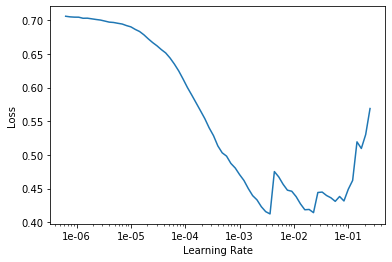

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)
# learner.fit_one_cycle(config.epochs, max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,0.569163,0.342171,00:13
1,0.332534,0.158780,00:13
2,0.231136,0.129460,00:13
3,0.178409,0.118935,00:13


In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
# learner.load(file=DATA_ROOT/'model1.pkl')
test_preds = get_preds_as_nparray(DatasetType.Test)

In [0]:
# sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")
# if config.testing: sample_submission = sample_submission.head(test.shape[0])
# sample_submission[label_cols] = test_preds
# sample_submission.to_csv(DATA_ROOT /"predictions.csv", index=False)

In [0]:
sample_submission=test
for label in label_cols:
  sample_submission[label]=0
sample_submission[label_cols] = test_preds
# sample_submission.to_csv(DATA_ROOT /"predictions_1.csv", index=False)
# sample_submission.sample(10000).to_csv(DATA_ROOT /"predictions_sample.csv", index=False)


In [0]:
sample_submission.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,0.485203,0.264738,0.235812,0.136724,0.318379,0.099121
1,== From RfC == \r\n\r\n The title is fine as i...,0.103930,0.038756,0.063599,0.030502,0.053800,0.032101
2,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto...",0.090093,0.042563,0.065247,0.033211,0.046638,0.040846
3,":If you have a look back at the source, the in...",0.078784,0.044101,0.070304,0.037538,0.051272,0.048226
4,I don't anonymously edit articles at all.,0.125601,0.043043,0.068413,0.032961,0.063019,0.031144


In [0]:
# sample_submission.to_csv(DATA_ROOT /"predictions.csv", index=False)

In [0]:
# learner.export(file=DATA_ROOT /"Model1.pkl")
# learner.save(file=DATA_ROOT/'Final_Model_BERT.pkl')

In [0]:
learner.validate()

[0.11893513]

In [0]:
# learner.save(file=DATA_ROOT/'Model2.pkl')